In [2]:
import os, sys
import json
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shutil import copyfile
from analysis.processing.utils import derive_session_type, get_sessions_list
from analysis.plots.utils import get_colors
from analysis.processing.epochs import get_epochs
from analysis.processing.metrics import get_field_match, get_fields_between_epochs
from analysis.adapters.hdf5 import H5NAMES
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
def get_sessions(source, animal):
    def is_dir(name):
        return os.path.isdir(os.path.join(source, animal, name))

    def has_h5(name):
        return os.path.exists(os.path.join(source, animal, name, '%s.h5' % H5NAMES.filebase))
    
    return [x for x in os.listdir(os.path.join(source, animal)) if is_dir(x) and has_h5(x)]

In [5]:
def get_idxs_by_quality(dataset):
    sic, pfr, iso = 0.2, 1.5, 15    # sic > 0.2, peak firing rate > 1.5 Hz, isolation distance > 15
    idxs_sic = (dataset['sic_A'] > sic) & (dataset['sic_B'] > sic)
    idxs_pfr = (dataset['peak_FR_A'] > pfr) & (dataset['peak_FR_B'] > pfr)
    idxs_iso = (dataset['isol_dist'] > iso)
    return idxs_sic & idxs_pfr & idxs_iso

In [6]:
source = '/home/andrey/storage2/andrey/data/processed'
source = '/storage2/andrey/data/processed'
#animals = ['003281', '003282', '003908', '003909', '005363']
animals = ['00908', '00910', '002784', '003281', '003282', '003908', '003909', '005363', '005364']
#animals = ['003281', '003282', '003908', '003909', '005363', '005364']

## Data selection

In [128]:
# pSHIFT
early_per = get_sessions_list(source, animals, 'SHIFT periodic')
early_per.remove(['00908', '2019-07-08_17-46-20', 'SHIFT periodic'])  # broken session
periodic = get_sessions_list(source, animals, 'SHIFT periodic +dark')
single = get_sessions_list(source, animals, 'SHIFT single +dark')

selected = early_per + periodic + single
        
pSHIFT = get_fields_between_epochs(source, selected, 'A', 'B')

No required H5 file found for 2020-10-23_12-57-03
PF match found for 1527 fields from total 3048 A and 3027 B fields


In [ ]:
coh_list_bl = get_sessions_list(source, animals, 'SHIFT both')
coh_list_bd = get_sessions_list(source, animals, 'SHIFT both +dark')

In [129]:
coherent = get_sessions_list(source, animals, 'SHIFT both +dark')
visual_snd = get_sessions_list(source, animals, 'SHIFT visual')
visual_s = get_sessions_list(source, animals, 'SHIFT visual +dark')  # these are all periodic!
visual_l = get_sessions_list(source, animals, 'SHIFT visual long +dark')  # these could be per / single

vSHIFT_s = get_fields_between_epochs(source, visual_snd + visual_s, 'A', 'B')
vSHIFT_l = get_fields_between_epochs(source, visual_l, 'A', 'B')

PF match found for 420 fields from total 801 A and 831 B fields
PF match found for 288 fields from total 516 A and 527 B fields


In [130]:
gain_12 = get_sessions_list(source, animals, 'GAIN 3 parts 1.2x')
gain_14 = get_sessions_list(source, animals, 'GAIN 3 parts 1.4x')  # 003281, 003282 - remove completely? wrong gain

vGAIN_s = get_fields_between_epochs(source, gain_12, 'A', 'B')
vGAIN_l = get_fields_between_epochs(source, gain_14, 'A', 'B')

PF match found for 574 fields from total 1080 A and 1030 B fields
PF match found for 683 fields from total 1484 A and 1452 B fields


422


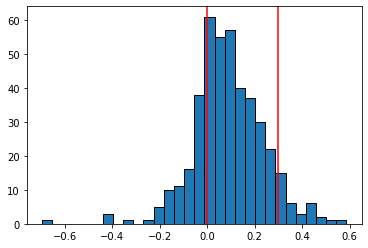

In [131]:
dff = vGAIN_l.copy()
#dff['shift'] = (-1) * (dff['shift'] - 0.3) # for physical only
dff['shift'] = (-1) * dff['shift']          # for visual only
dff = dff[get_idxs_by_quality(dff)]

print(len(dff))

plt.hist(dff['shift'], 30, ec='black')
plt.axvline(0, color='red')
plt.axvline(0.3, color='red')

## Copy figures

In [132]:
# copy figures
dest = '/storage2/andrey/data/projects/24_shift/debug'
dest = '/home/andrey/storage2/andrey/data/projects/24_shift/debug'

# selection
#df_sel = dff[(dff['shift'] < 0.03) | (dff['shift'] > 0.35)]
df_sel = vGAIN_l.copy()
df_sel = df_sel[get_idxs_by_quality(df_sel)]

# delete files inside debug
for f in os.listdir(dest):
    os.remove(os.path.join(dest, f))

for i, row in df_sel.iterrows():
    f_path = os.path.join(source, row['animal'], row['session'], 'analysis', 'placefields')
    f_name = '%s_%s_%s_%s.png' % (row['animal'], row['session'], row['electrode'], row['unit'])
    copyfile(os.path.join(f_path, f_name), os.path.join(dest, "%s_%s" % (str(i), f_name)))

## Filter clusters

In [139]:
# 5363 2021-01-26_17_27_26 - Rotate session!
# 3281 2019-10-23_22-25-54 - PF images are broken

In [9]:
bad_clu_dir = '/storage2/andrey/data/projects/24_shift/bad_clusters'
#bad_clu_dir = '/home/andrey/storage2/andrey/data/projects/24_shift/bad_clusters'

In [136]:
def get_sessions_by_idxs(ds, idxs):
    bad_clusters = []
    for i, row in ds.iterrows():
        if i in idxs:
            bad_clusters.append([row['animal'], row['session'], row['electrode'], row['unit']])

    return pd.DataFrame(bad_clusters, columns=['animal', 'session', 'electrode', 'unit'])    

In [61]:
# vSHIFT short
# 3, 10, 11, 12, 22, 30, 31, 39, 51, 52, 63, 71, 72, 82, 84, 106, 126, 128, 129?, 135, 147, 150?, 156?, \
#   165, 166, 168, 178, 182, 216, 222, 224, 225, 227, 228, 229, 236, 244R, 246, 249, 250, 256R, 261, 263, \
#   264R, 272, 289, 293, 294, 297, 298?, 301, 316, 339?, 364, 369, 381, 410, 419
items = [3, 10, 11, 12, 22, 30, 31, 39, 51, 52, 63, 71, 72, 82, 84, 106, 126, 128, 135, 147, \
         165, 166, 168, 178, 182, 216, 222, 224, 225, 227, 228, 229, 236, 244, 246, 249, 250, \
         256, 261, 263, 264, 272, 289, 293, 294, 297, 301, 316, 339, 364, 369, 381, 410, 419]

dff = vSHIFT_s.copy()
dff['shift'] = (-1) * dff['shift']          # for visual only
dff = dff[get_idxs_by_quality(dff)]
        
bad = get_sessions_by_idxs(dff, items)
bad.to_csv(os.path.join(bad_clu_dir, 'vSHIFTs.csv'), index=False)


# vSHIFT long
# 25, 27, 68, 101, 114?, 137, 163, 218, 225, 247, 250, 253?, 264, 266, 269, 275, 280, 281, 284
items = [25, 27, 68, 101, 114, 137, 163, 218, 225, 247, 250, 253, 264, 266, 269, 275, 280, 281, 284]

dff = vSHIFT_l.copy()
dff['shift'] = (-1) * dff['shift']          # for visual only
dff = dff[get_idxs_by_quality(dff)]
        
bad = get_sessions_by_idxs(dff, items)
bad.to_csv(os.path.join(bad_clu_dir, 'vSHIFTl.csv'), index=False)

In [71]:
# pSHIFT
# 5, 7, 12, 14, 17, 24, 25, 26, 30, 39, 114, 115, 146, 170, 173, 207, 232, 239, 244, 245, 263, 264, 284, 310,\
#  316, 365, 370, 402, 432, 446, 448, 452, 475, 569, 585, 612, 627, 659, 716, 734, 750, 771, 781, 791, 823, \
#  828, 832, 844, 848, 885, 893, 902, 905, 906, 908, 948, 953, 974, 984, 998, 1014, 1036, 1047, 1060, 1064, \
#  1073, 1074, 1076, 1093, 1101, 1137, 1141, 1147, 1148, 1150, 1200, 1206, 1209, 1258, 1259, 1262, 1263, \
#  1264, 1292, 1326, 1334, 1341, 1349, 1391, 1402, 1411

items = [5, 7, 12, 14, 17, 24, 25, 26, 30, 39, 114, 115, 146, 170, 173, 207, 232, 239, 244, 245, 263, 264, 284, 310,\
  316, 365, 370, 402, 432, 446, 448, 452, 475, 569, 585, 612, 627, 659, 716, 734, 750, 771, 781, 791, 823, \
  828, 832, 844, 848, 885, 893, 902, 905, 906, 908, 948, 953, 974, 984, 998, 1014, 1036, 1047, 1060, 1064, \
  1073, 1074, 1076, 1093, 1101, 1137, 1141, 1147, 1148, 1150, 1195, 1199, 1209, 1218, 1267, 1268, 1271, 1272, \
  1273, 1301, 1323, 1331, 1335, 1343, 1350, 1358, 1360, 1363, 1400, 1420, 1473, 1477, 1480, 1487, 1492, 1493, 1499, 1525]

dff = pSHIFT.copy()
dff['shift'] = (-1) * (dff['shift'] - 0.3)   # for physical only
dff = dff[get_idxs_by_quality(dff)]

bad_clusters = []
for i, row in dff.iterrows():
    if i in items:
        bad_clusters.append([row['animal'], row['session'], row['electrode'], row['unit']])
        
bad = pd.DataFrame(bad_clusters, columns=['animal', 'session', 'electrode', 'unit'])
bad.to_csv(os.path.join(bad_clu_dir, 'pSHIFT.csv'), index=False)

In [137]:
# vGAIN short
items = [3, 31, 32, 331, 336, 339, 353, 362, 367, 373, 378, 38, 383, 385, 387, 389, 393, 404, 407, \
         415, 421, 427, 437, 452, 459, 463, 471, 481, 491, 504, 509, 511, 514, 522, 524, 525, 539, \
         547, 60, 112, 13, 131, 133, 155, 166, 181, 187, 192, 20, 204, 216, 224, 226, 23, 235, 240, 24, 274, 285]

dff = vGAIN_s.copy()
dff['shift'] = (-1) * dff['shift']          # for visual only
dff = dff[get_idxs_by_quality(dff)]
        
bad = get_sessions_by_idxs(dff, items)
bad.to_csv(os.path.join(bad_clu_dir, 'vGAINs.csv'), index=False)


# vGAIN long
items = [42, 49, 79, 86, 88, 89, 91, 105, 110, 115, 117, 146, 151, 155, 156, 158, 160, 171, 181, \
         183, 184, 193, 194, 204, 205, 208, 222, 232, 269, 272, 308, 334, 342, 352, 354, 371, \
         380, 381, 410, 420, 432, 443, 448, 455, 457, 462, 474, 480, 482, 496, 505, 513, 546, \
         566, 582, 643, 652, 663, 671, 681]

dff = vGAIN_l.copy()
dff['shift'] = (-1) * dff['shift']          # for visual only
dff = dff[get_idxs_by_quality(dff)]
        
bad = get_sessions_by_idxs(dff, items)
bad.to_csv(os.path.join(bad_clu_dir, 'vGAINl.csv'), index=False)

In [12]:
# Coherent - manually

bad_clusters = [
    ['003909', '2020-03-28_18-36-22', 1, 6],
    ['003909', '2020-03-28_18-36-22', 1, 7],
    ['003909', '2020-03-28_18-36-22', 1, 9],
    ['003909', '2020-03-28_18-36-22', 3, 6],
    ['003909', '2020-03-28_18-36-22', 3, 7],
    ['003909', '2020-03-28_18-36-22', 3, 4],
    ['003909', '2020-03-28_18-36-22', 6, 3],
    ['003909', '2020-03-28_18-36-22', 7, 3],
    
    ['003282', '2019-12-05_10-04-14', 6, 3],
    ['003282', '2019-12-05_10-04-14', 6, 8],
    ['003282', '2019-12-05_10-04-14', 6, 9],
    ['003282', '2019-12-03_10-36-38', 6, 8],
    ['003282', '2019-12-03_10-36-38', 6, 9],
    ['003282', '2019-12-03_10-36-38', 6, 10],
    
    ['003282', '2019-11-18_21-48-32', 3, 2],
    ['003282', '2019-11-18_21-48-32', 3, 8],
    ['003282', '2019-11-18_21-48-32', 4, 4],
    ['003282', '2019-11-18_21-48-32', 4, 5],
    ['003282', '2019-11-18_21-48-32', 4, 6],
    ['003282', '2019-11-18_21-48-32', 4, 7],
    ['003282', '2019-11-18_21-48-32', 7, 4],
    ['003282', '2019-11-18_21-48-32', 7, 5],
    
    ['003282', '2019-12-03_10-36-38', 5, 6],
    ['003908', '2020-05-05_18-10-25', 3, 10],
    ['003908', '2020-05-05_18-10-25', 3, 9],
    ['003908', '2020-05-05_18-10-25', 4, 5],
    
    ['005363', '2020-10-27_09-46-06', 2, 2],
    ['005363', '2020-10-27_09-46-06', 2, 4],
    ['005363', '2020-10-27_09-46-06', 2, 7],
    ['003908', '2020-05-05_18-10-25', 4, 5],

    
    ['003281', '2019-11-18_22-10-40', 2, 2],
    ['003281', '2019-11-18_22-10-40', 2, 4],
    ['003281', '2019-11-18_22-10-40', 2, 6],
    ['003281', '2019-11-18_22-10-40', 2, 7],
    ['003281', '2019-11-18_22-10-40', 3, 9]
]

coh_bad = pd.DataFrame(bad_clusters, columns=['animal', 'session', 'electrode', 'unit'])   
coh_bad.to_csv(os.path.join(bad_clu_dir, 'cSHIFT.csv'), index=False)

In [13]:
# combine all
col_types = {'animal': str, 'session': str, 'electrode': int, 'unit': int}

frames = []
for fname in ['pSHIFT', 'vSHIFTs', 'vSHIFTl', 'vGAINs', 'vGAINl', 'cSHIFT']:
    df = pd.read_csv(os.path.join(bad_clu_dir, '%s.csv' % fname), dtype=col_types)
    frames.append(df)

bad_all = pd.concat(frames)
bad_all.to_csv(os.path.join(bad_clu_dir, 'all.csv'), index=False)